In [8]:
import os
import pandas as pd
import numpy as np
import datetime 
import warnings
import pytz
warnings.filterwarnings('ignore')


In [111]:
class nmdx_file_parser:
    """
    A class used to read raw data file(s) and convert to flat format.

    Methods
    -------
    scrapeFile(file=None, env=None)
        Scrapes data from one raw data file.
    """
    def __init__(self):
        self.file_data = {}

    def readChannelData(file, sheet, channel):

        channelData_all = pd.read_excel(io=file,sheet_name=sheet)
        if len(channelData_all) > 0:
            ChannelRawStart = channelData_all[channelData_all['Sample ID']=='Raw'].index.values[0] + 1
            ChannelRawEnd = channelData_all[channelData_all['Sample ID']=='Normalized'].index.values[0] - 2
            ChannelRaw = channelData_all.loc[ChannelRawStart:ChannelRawEnd]
            ChannelRaw['Processing Step'] = 'Raw'

            ChannelNormStart = channelData_all[channelData_all['Sample ID']=='Normalized'].index.values[0] + 1
            ChannelNormEnd = channelData_all[channelData_all['Sample ID']=='SecondDerivative'].index.values[0] - 2
            ChannelNorm = channelData_all.loc[ChannelNormStart:ChannelNormEnd]
            ChannelNorm['Processing Step'] = 'Normalized'

            Channel2ndStart = channelData_all[channelData_all['Sample ID']=='SecondDerivative'].index.values[0] + 1

            if 'Modulated' in channelData_all['Sample ID'].unique():
                Channel2ndEnd = channelData_all[channelData_all['Sample ID']=='Modulated'].index.values[0] - 2
                ChannelModulatedStart = channelData_all[channelData_all['Sample ID']=='Modulated'].index.values[0] + 1
                ChannelModulated = channelData_all.loc[ChannelModulatedStart:ChannelModulatedStart+len(ChannelRaw)]
                ChannelModulated['Processing Step'] = 'Modulated'
                Channel2nd = channelData_all.loc[Channel2ndStart:Channel2ndEnd]
                Channel2nd['Processing Step'] = '2nd'

                if len(ChannelRaw) == len(ChannelNorm) and len(ChannelRaw) == len(Channel2nd) and len(ChannelRaw) == len(ChannelModulated):

                    ChannelFinal = pd.concat([ChannelRaw, ChannelNorm, Channel2nd, ChannelModulated],axis=0)
                    ChannelFinal['Channel'] = channel
                    ChannelFinal.set_index(['Test Guid', 'Replicate Number'],inplace=True)
                else:
                    print("Error in parsing Datablocks")
            else:
                Channel2nd = channelData_all.loc[Channel2ndStart:Channel2ndStart+len(ChannelRaw)]
                Channel2nd['Processing Step'] = '2nd'
                #if len(ChannelRaw) == len(ChannelNorm) and len(ChannelRaw) == len(Channel2nd):
                ChannelFinal = pd.concat([ChannelRaw, ChannelNorm, Channel2nd],axis=0)
                ChannelFinal['Channel'] = channel
                ChannelFinal.set_index(['Test Guid', 'Replicate Number'],inplace=True)


        else:
            ChannelFinal = pd.DataFrame()



        return ChannelFinal
    
    def readRawData(file):
        channelDict = {'Green_470_510':'Green',
                    'Yellow_530_555':'Yellow',
                    'Orange_585_610':'Orange',
                    'Red_625_660':'Red',
                    'Far_Red_680_715':'Far_Red'}

        Summary_Tab = pd.read_excel(io=file,sheet_name='Summary',header=2)
        COC_Tab = pd.read_excel(io=file,sheet_name='Chain of Custody')
        Summary_COC_Data = Summary_Tab.set_index(['Test Guid', 'Replicate Number']).join(COC_Tab.set_index(['Test Guid', 'Replicate Number']).loc[:, [x for x in COC_Tab.columns if x not in Summary_Tab.columns]])


        channelDataDict = {}
        for channel in channelDict:
            channelDataDict[channel] = nmdx_file_parser.readChannelData(file, channel, channelDict[channel])
        channelDataFinal = pd.concat([channelDataDict[df] for df in channelDataDict if len(channelDataDict[df])>0],axis=0)

        
        channelDataFinal.set_index(['Target Result Guid', 'Processing Step', 'Channel'],append=True,inplace=True)
        for i in range(1,256):
            if "Readings "+ str(i) not in channelDataFinal.columns:
                channelDataFinal["Readings "+str(i)] = np.nan
        channelDataFinal_readings = channelDataFinal.loc[:, ['Readings '+str(i) for i in range(1,256)]]
        channelDataFinal_summary = channelDataFinal.swaplevel(3,0).swaplevel(3,1).swaplevel(3,2)
        channelDataFinal_summary = channelDataFinal_summary.loc['Raw'].drop(['Readings '+str(i) for i in range(1,256)],axis=1)

        return Summary_COC_Data, channelDataFinal_summary, channelDataFinal_readings
    
    def retrieveConsumableLots(data, consumable_types=['Pcr Cartridge', 'Capture Plate', 'Test Strip NeuMoDx', 'Buffer', 'Release Reagent', 'Wash Reagent']):
        """
        Retrieves Lot information for NMDX Consumables from Barcode String
        :param consumable_types: list-like List of Consumables to get Data For.
        """
    
        for consumable_type in consumable_types:
            data[consumable_type+" Lot"] = data[consumable_type+" Barcode"].str[18:24]

        return data

    def retrieveConsumableSerials(data, consumable_types=['Pcr Cartridge', 'Capture Plate', 'Test Strip NeuMoDx', 'Buffer', 'Release Reagent', 'Wash Reagent']):
        """
        Retrieves Consumable Serial information for NMDX Consumables from Barcode String
        :param consumable_types: list-like List of Consumables to get Data For
        """
        
        for consumable_type in consumable_types:
            data[consumable_type+" Serial"] = data[consumable_type+" Barcode"].str[27:32]

        return data

    def retrieveConsumableExpiration(data, consumable_types=['Pcr Cartridge', 'Capture Plate', 'Test Strip NeuMoDx', 'Buffer', 'Release Reagent', 'Wash Reagent']):
        """
        Retrieves Expiration Date information for NMDX Consumables from Barcode String
        :param consumable_types: list-like List of Consumables to get Data For.
        """
    
        for consumable_type in consumable_types:
            data[consumable_type+" EXP Date"] = data[consumable_type+" Barcode"].str[-6:].apply(lambda x: pd.to_datetime(arg=x, format="%y%m%d"))

        return data

    def scrapeFile(self, file, filename):
           
        #time = pd.Timestamp.now()

        summary_coc, channel_summary, channel_readings = nmdx_file_parser.readRawData(file)
        for col in channel_summary.columns:
            if 'Barcode' in col:
                channel_summary[col] = channel_summary[col].astype(str)
                channel_summary[col] = channel_summary[col].str.replace("_x001D_", " ")
        channel_summary = channel_summary.astype(object).where(pd.notna(channel_summary), None)


        for col in summary_coc.columns:
            if 'Barcode' in col:
                summary_coc[col] = summary_coc[col].astype(str)
                summary_coc[col] = summary_coc[col].str.replace("_x001D_", " ")
            if 'ADP Position' in col:
                summary_coc[col] = summary_coc[col].astype(str)
        summary_coc = summary_coc.astype(object).where(pd.notna(summary_coc), None)
        for col in summary_coc.loc[:, [col for col in summary_coc if 'Date' in col]].columns:
            summary_coc[col] = pd.to_datetime(summary_coc[col], utc=False).apply(lambda x: x.replace(tzinfo=pytz.utc))
        
        channel_readings = channel_readings.astype(object).where(pd.notna(channel_readings), None)

        channel_summary['File Source'] = filename
        channel_readings['File Source'] = filename
        summary_coc['File Source'] = filename
        summary_coc.rename({'Flags':'Summary Flags'},axis=1,inplace=True)
        channel_summary.rename({'Flags':'Channel Flags'},axis=1,inplace=True)
        summary_coc = nmdx_file_parser.retrieveConsumableLots(summary_coc)
        summary_coc = nmdx_file_parser.retrieveConsumableSerials(summary_coc)
        summary_coc = nmdx_file_parser.retrieveConsumableExpiration(summary_coc)
        
        

        flat_data = summary_coc.join(channel_summary.loc[:, [x for x in channel_summary.columns if x not in summary_coc.columns]]).join(channel_readings.loc[:, [x for x in channel_readings.columns if x not in channel_summary.columns]])
        
        ##Add Target Result / Localized Result columns if not in flat_data columns
        if 'Localized Result' not in flat_data.columns:
            flat_data['Localized Result'] = np.nan
        
        if 'Target Result' not in flat_data.columns:
            flat_data['Target Result'] = np.nan

        return flat_data.reset_index()
myParser = nmdx_file_parser()
raw_data = myParser.scrapeFile(file='Example/RawDataExport.NDX-03.12000112.2207211558.016653D0.xlsx', filename='test')


class TadmHelper:

    def __init__(self, raw_data):
        """
        Parameters
        ----------
        raw_data pd.DataFrame: A Raw Data DataFrame in Flat format.
        """
        self.tadm_data = pd.DataFrame()
        self.raw_data = raw_data.copy()
        self.raw_data.drop_duplicates(subset=['Test Guid', 'Replicate Number'], inplace=True)
        self.raw_data_liquid_handle_processes = self.raw_data[['Test Guid', 'Replicate Number', 'Sample ID', 'Start Date/Time', 'LHPA Start Date Time', 'LHPB Start Date Time', 'LHPC Start Date Time', 'PCR Start Date Time', 'LHPA ADP Position', 'LHPB ADP Position', 'LHPC ADP Position']]

        self.processGroups = {}
        for process in ['LHPA', 'LHPB', 'LHPC']:
            self.processGroups[process] = self.raw_data[[process+' Start Date Time']].drop_duplicates([process+' Start Date Time']).dropna().sort_values(process+' Start Date Time').reset_index(drop=True)


    def get_tadms(self, file_dir):
        """
        A function used to prepare a the tadm_data by merging together data found within a directory.

        Parameters
        ----------
        file_dir (str): Name of File Directory to Search for Files within.
        """
        files = ['Example/'+x for x in os.listdir(file_dir)]
        files
        curvefile = [x for x in files if 'Curves' in x][0]
        curves_df = pd.read_csv(curvefile).set_index(['CurveID', 'Sheet'])
        pressurevalues = {}
        ##Get unique pressurevalues
        for pressurevalue in curves_df.index.unique(1):
            df = pd.read_csv([x for x in files if pressurevalue in x][0])
            df = df.set_index('Time').transpose()
            df['Sheet'] = pressurevalue
            df.index.names = ['CurveID']
            df.reset_index(inplace=True)
            df['CurveID'] = df['CurveID'].astype(int)
            df.set_index(['CurveID','Sheet'], inplace=True)
            df = df.join(curves_df)
            pressurevalues[pressurevalue] = df

        self.tadm_data = pd.concat([pressurevalues[df] for df in pressurevalues],axis=0).set_index(['LiquidClassName',
                                                                                    'Volume',
                                                                                    'StepType',
                                                                                    'Channel',
                                                                                    'Time',
                                                                                    'StepNumber',
                                                                                    'TadmMode',
                                                                                    'TadmError'],append=True)

    def closest_match(self, sample, main_process, max_time_offset=15, min_time_offset=0):
        """
        A function used to apply fuzzy logic to find tadms associated with a NeuMoDx Sample

        Parameters:
        ----------
        Sample (pd.DataFrame):  a slice of one row of data from NeuMoDx Raw Data
        main_process (str): Main Liquid Handling Process (LHPA, LHPB, LHPC) to use as time reference. 
        max_time_offset (int): An offset in seconds to apply to the maximum time bound applied to TADM search range.
        min_time_offset (int): An offset in seconds to apply to the minimum time bound applied to TADM search range.
        """
        def find_tadms(channel, repeat_offset=0):
            ##Get Test Guid of Sample
            test_guid = sample['Test Guid'].values[0]
            rep_number = sample['Replicate Number'].values[0]
            
            ##Convert Associated Start Date Time to be utc agnostic
            sample[main_process+' Start Date Time'] = sample[main_process+' Start Date Time'].apply(lambda x: x.replace(tzinfo=pytz.utc))
            
            ##Get Time of associated Sample
            time = sample[main_process+' Start Date Time'].astype('datetime64[ns]').values[0]
            
            ##Determine the processing group sample is associated with
            processGroupTimes = self.processGroups[main_process]
            processGroupTimes[main_process+" Start Date Time"] = processGroupTimes[main_process+" Start Date Time"].astype('datetime64[ns]')
            processGroupTimes['Reference Time'] = time
            processGroupTimes['Delta Time'] = abs(processGroupTimes[main_process+" Start Date Time"]-processGroupTimes['Reference Time'])
            
            ##Determine Minimum and Maximum Bounds for time allowed to search within.
            minimum_time_bound_index = processGroupTimes.loc[processGroupTimes['Delta Time']==processGroupTimes['Delta Time'].min(), main_process+" Start Date Time"].index.values[0]
            
            ##Apply a -1 run group offset in the case of a first time repeated sample.
            minimum_time_bound_index = minimum_time_bound_index - repeat_offset

            ##Get Value of minimum_time_bound
            minimum_time_bound = processGroupTimes.loc[minimum_time_bound_index, main_process+" Start Date Time"] - np.timedelta64(min_time_offset, 's')
            time = processGroupTimes.loc[minimum_time_bound_index, main_process+" Start Date Time"]

            if minimum_time_bound_index+1 < len(processGroupTimes):
                maximum_time_bound = processGroupTimes.loc[minimum_time_bound_index+1, main_process+" Start Date Time"] + np.timedelta64(max_time_offset, 's')
            else:
                maximum_time_bound = minimum_time_bound + np.timedelta64(5, 'm')
            

            
            ##Filter TADM Reference to only be for the Channel and Time Range allowed to search within
            tadm_reference_channel = self.tadm_data.reset_index(['Channel', 'LiquidClassName', 'StepType','Time'])
            tadm_reference_channel['Time'] = tadm_reference_channel['Time'].astype('datetime64[ns]')
            tadm_reference_channel = tadm_reference_channel[((tadm_reference_channel['Channel']==channel)&
                                                            (tadm_reference_channel['Time']>minimum_time_bound)&
                                                            (tadm_reference_channel['Time']<maximum_time_bound))]
            
            
            ##Determine Delta Time from Time observed for sample process
            tadm_reference_channel['Reference Time'] = time
            tadm_reference_channel['Delta Time'] = (tadm_reference_channel['Time']  - tadm_reference_channel['Reference Time']).astype('timedelta64[s]')

            ##Add Test Guid to TADM reference
            tadm_reference_channel['Test Guid'] = test_guid
            tadm_reference_channel['Replicate Number'] = rep_number
            tadm_reference_channel = tadm_reference_channel.reset_index()[['CurveID', 'Test Guid', 'Replicate Number', 'Delta Time', 'LiquidClassName', 'StepType']].sort_values('Delta Time')
            
            ##Filter to make sure that we are only grabbing TADMs that we would expect based on process.
            if main_process == 'LHPB':
                tadm_reference_channel = tadm_reference_channel[((tadm_reference_channel['LiquidClassName'].str.contains(main_process))|(tadm_reference_channel['LiquidClassName'].str.contains('High')))]
            else:
                tadm_reference_channel = tadm_reference_channel[((tadm_reference_channel['LiquidClassName'].str.contains(main_process)))]

            ##Drop any duplicates that may have been found, keep lowest time delta.
            tadm_reference_channel.drop_duplicates(['LiquidClassName','StepType'],keep='first',inplace=True)
            
            
            return tadm_reference_channel


        channel = sample.loc[:, main_process+' ADP Position'].values[0]
        

        ##Determine which Channel to work with and if a sample is a aborted, or repeated sample.
        if pd.isnull(channel) or "nan" in channel:
            print("channel not found error")
            return

        elif "," in channel:
            channel_1 = pd.to_numeric(channel[-1])
            set1 = find_tadms(channel_1)
            channel_2 = pd.to_numeric(channel[0])
            set2 = find_tadms(channel_2, repeat_offset=1)
            return pd.concat([set1, set2],axis=0).drop_duplicates(['CurveID'],keep='first')
        else:
            channel = pd.to_numeric(channel)
            set1 = find_tadms(channel)
            return set1

    def tadm_hunter(self):
        self.conversion_frame = pd.DataFrame(columns=['CurveID', 'Test Guid', 'Replicate Number'])
        for id in self.raw_data_liquid_handle_processes.index.values:
            for process in ['LHPA', 'LHPB', 'LHPC']:
                self.conversion_frame = pd.concat([self.conversion_frame, self.closest_match(self.raw_data_liquid_handle_processes.loc[[id]], process)],axis=0)
                
        self.conversion_frame = self.conversion_frame[['Test Guid', 'Replicate Number', 'CurveID']].set_index(['Test Guid','Replicate Number', 'CurveID'])

    def tadm_merger(self, raw_data_file_columns=['Test Guid', 'Sample ID', 'Replicate Number', 'XPCR Module Serial', 'XPCR Module Index', 'Pcr Cartridge Lane', 'Heater Module Serial', 'Heater Module Index', 'Capture Plate Well']):

        raw_data_index = self.raw_data.loc[:, raw_data_file_columns].set_index(['Test Guid', 'Replicate Number'])

        raw_data_index = raw_data_index.join(self.conversion_frame)
        merged_data = raw_data_index.join(self.tadm_data.reset_index().set_index('CurveID'))
        return merged_data.reset_index().set_index([ 'Sample ID', 'Replicate Number', 'Test Guid', 'LiquidClassName', 'StepType', 'Volume', 'TadmError', 'Time', 'CurveID'])


In [112]:
myTadmHelper = TadmHelper(raw_data)
myTadmHelper.get_tadms('Example')
myTadmHelper.tadm_hunter()

channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error
channel not found error


In [116]:
TADM_frame = myTadmHelper.tadm_merger()

In [118]:
TADM_frame_groups = TADM_frame.reset_index().set_index(['LiquidClassName', 'StepType'])

In [124]:
TADM_types = [x for x in TADM_frame_groups.index.unique()]

In [143]:
item

('NMDX_LHPA_Buffer_TADM', 'Aspirating')

In [148]:
plotData.loc[item].head(50)

LiquidClassName                        NMDX_LHPA_Buffer_TADM
StepType                                          Aspirating
Sample ID                                     BKV 10m4 U R10
Replicate Number                                           1
Test Guid               0080c1ae-1609-ed11-85f4-5cf370a20867
Volume                                                   700
TadmError                                                  0
Time                                   7/21/2022 12:01:18 PM
CurveID                                                 1832
Heater Module Serial                                     156
Heater Module Index                                        4
Capture Plate Well                                        24
Sheet                                        PressureValues0
Channel                                                    3
StepNumber                                              6212
TadmMode                                                   0
0                       

ValueError: Could not interpret value `V639` for parameter `hue`

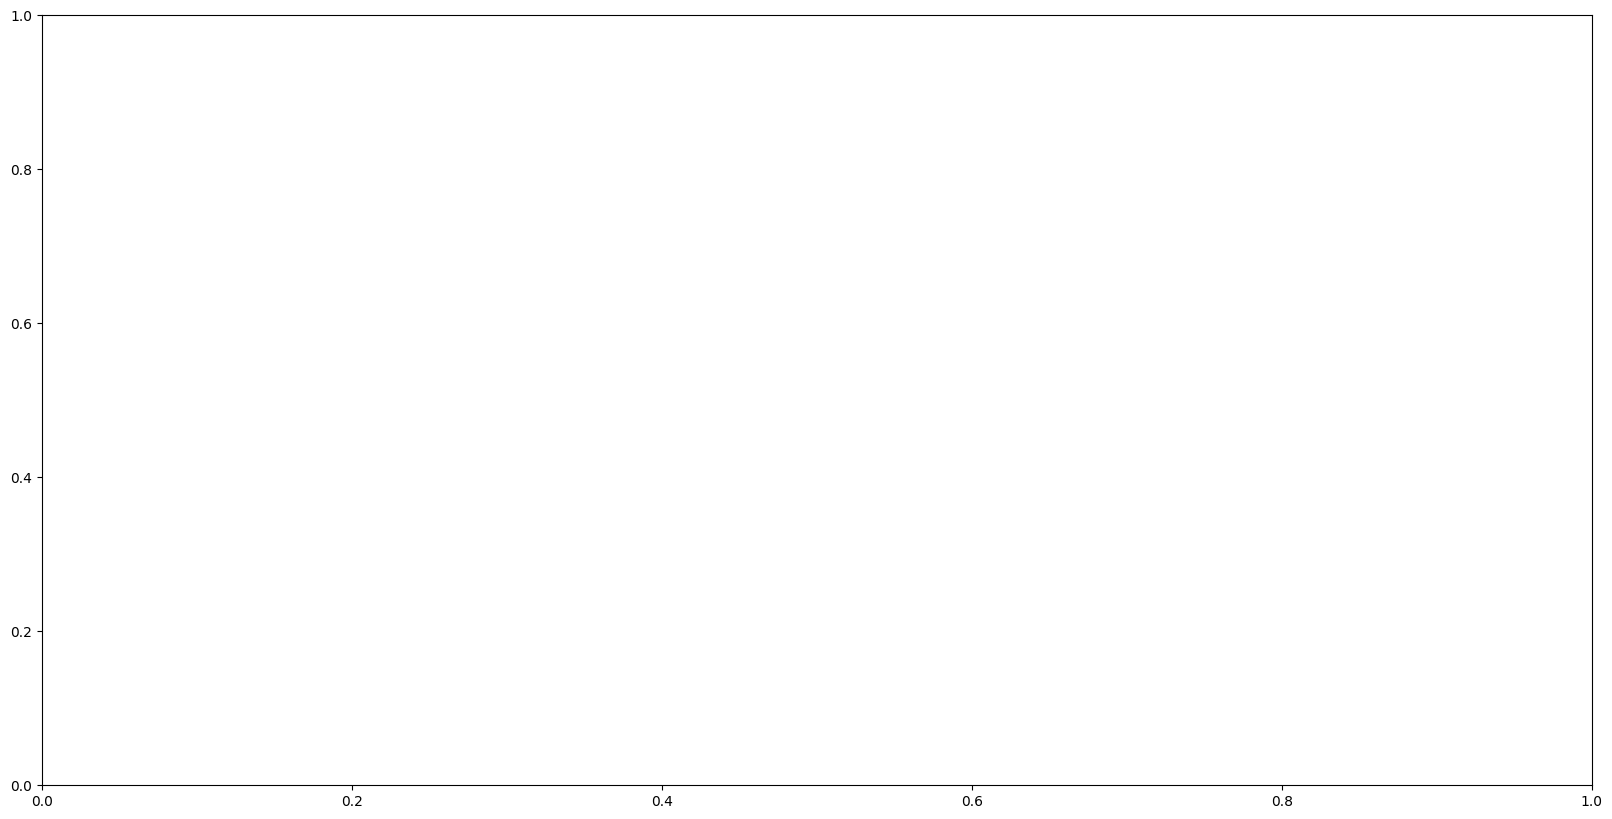

In [154]:
import matplotlib.pyplot as plt 
import seaborn as sns

group_col = ''
fig, ax = plt.subplots(1,1, figsize=(20,10))

plotData = TADM_frame_groups.loc[TADM_types[0]].reset_index()

for x in plotData.columns:
    if isinstance(x, int):
        if plotData[x].isnull().values.any():
            plotData.drop(x, axis=1, inplace=True)

pressure_cols = [x for x in plotData.columns if isinstance(x, int)]

palet

for item in plotData.index:
    sns.lineplot(x=pressure_cols, y=plotData.loc[item, pressure_cols].values, hue=plotData.loc[item, 'XPCR Module Serial'])
    

